loganjtravis@gmail.com (Logan Travis)

In [1]:
%%capture --no-stdout

# Imports; captures errors to supress warnings about changing
# import syntax
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import matplotlib
import nltk
import numpy as np
import pandas as pd
import random
import re
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import unidecode

In [2]:
# Set random seed for repeatability
random.seed(42)

In [3]:
# Set matplotlib to inline to preserve images in PDF
%matplotlib inline

# Summary

From course page [Week 4 > Task 4 and 5 Information > Task 4 and 5 Overview](https://www.coursera.org/learn/data-mining-project/supplement/gvCsC/task-4-and-5-overview):

> The general goal of Tasks 4 and 5 is to leverage recognized dish names to further help people making dining decisions. Specifically, Task 4 is to mine popular dishes in a cuisine that are liked by people; this can be very useful for people who would be interested in trying a cuisine that they might not be familiar with. Task 5 is to recommend restaurants to people who would like to have a particular dish or a certain type of dishes. This is directly useful to help people choose where to dine.
> 
> ...
> 
> **Instructions**
> Some questions to consider when working on Tasks 4 & 5:
> 
> 1. Given a cuisine and a set of candidate dish names of the cuisine, how do we quantify the popularity of a dish? How can we discover the popular dishes that are liked by many reviewers? What kind of dishes should be ranked higher in general if we are to recommend dishes of a cuisine for people to try? Would the number of times a dish is mentioned in all the reviews be a better indicator of a popular dish than the number of restaurants whose reviews mentioned the dish?
> 2. For people who are interested in a particular dish or a certain type of dishes, which restaurants should be recommended? How can we design a ranking function based on the reviews of the restaurants that mention the particular dish(es)? Should a restaurant with more dish name occurrences be ranked higher than one with more unique dish names?
> 3. How can you visualize the recommended dishes for a cuisine and the recommended restaurants for particular dishes to make them as useful as possible to users? How can the visualization be incorporated into a usable system? For example, you can imagine using the algorithms you developed for Tasks 4 and 5 to construct a system that allows a user to select a cuisine to see the favorite/popular dishes of the cuisine and further recommends the best restaurants if a user selects a particular dish or a set of dishes that are interesting to him/her.

# Task 04: Mine Popular Dishes

*

In [4]:
# Set paths to data source, work in process ("WIP"), and output
PATH_SOURCE = "source/"
PATH_WIP = "wip/"
PATH_OUTPUT = "output/"

# Set file paths
PATH_SOURCE_MEXICAN_LABELS = PATH_SOURCE + "labels/Mexican_FINAL.label"
PATH_SOURCE_YELP_REVIEWS = PATH_SOURCE + \
        "yelp_academic_dataset_review.pkl.gzip"
PATH_SOURCE_YELP_REST_TO_CUISINES = PATH_SOURCE + \
        "yelp_academic_dataset_restaurant_to_cuisine.pkl.gzip"
PATH_SOURCE_YELP_BUSINESSES = PATH_SOURCE + \
        "yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json"

## Get Dishes for Mexican Cuisine

In [5]:
# Get dishes for Mexican cuisine
dfMexDishes = pd.read_csv(PATH_SOURCE_MEXICAN_LABELS, names=["dish"])

In [6]:
# Strip accents from dish names
dfMexDishes.dish = dfMexDishes.dish.transform(unidecode.unidecode)

## Get Reviews from Mexican Restaurants

In [7]:
# Read saved data
dfYelpReviews = pd.read_pickle(PATH_SOURCE_YELP_REVIEWS)
dfYelpRestToCuis = pd.read_pickle(PATH_SOURCE_YELP_REST_TO_CUISINES)

In [8]:
# Filter restaurants to those tagged with "Mexican" category
dfYelpRestMexican = dfYelpRestToCuis[dfYelpRestToCuis.categories.apply(\
        lambda cats: "Mexican" in cats)]

In [9]:
# Join (inner) reviews to restaurants
dfYelpReviews = dfYelpReviews.join(dfYelpRestMexican, \
                                   on="business_id", \
                                   how="inner", \
                                   rsuffix="_business")

In [10]:
# Reset index to simple integer; simplifies document selection
# in TF matrix
dfYelpReviews.reset_index(inplace=True)

## Rank Dishes by Frequency in Reviews (simple)

*

In [11]:
# Set minimum and maximum n-gram length; Note: Dish names
# set to maximum of trigram in task 03
NGRAM_RANGE = (1, 3)

# Convert dish dataframe to vocabulary dictionary for
# use in `CountVectorizer`
DISH_DICT = dfMexDishes.dish.to_dict() # {index:dish}
DISH_DICT = {v: k for k, v in DISH_DICT.items()} # {dish:index}

In [12]:
class MyTokenizer:
    def __init__(self):
        """String tokenizer utilizing lemmatizing and stemming."""
        self.wnl = nltk.stem.WordNetLemmatizer()
    
    def __call__(self, document):
        """Return tokens from a string."""
        return [self.wnl.lemmatize(token) for \
                        token in nltk.word_tokenize(document)]

In [13]:
# Create dish frequency vectorizer 
dishFreq = CountVectorizer(strip_accents="unicode", stop_words="english", \
                           tokenizer=MyTokenizer(), ngram_range=NGRAM_RANGE, \
                           vocabulary=DISH_DICT, binary=True)

In [14]:
%%time

# Calculate dish frequencies
dishInReview = dishFreq.fit_transform(dfYelpReviews.text)

CPU times: user 1min 43s, sys: 234 ms, total: 1min 43s
Wall time: 1min 48s


In [15]:
# Append dish count to dataframe; CAUTION: Make sure
# dataframe of mexican dishes sorted in ascending index
# order or values will map incorrectly.
# dfMexDishes.sort_index(inplace=True)
dfMexDishes["count_in_reviews"] = dishInReview.sum(axis=0).A[0]

In [16]:
def getBarParamsFromDish(dataframe, heightCol, labelCol, topN=20):
    """Return axis positions (ticks), bar heights, and labels for plotting
            a bar chart from ranked dishes."""
    data = dataframe.sort_values(by=heightCol, ascending=False)\
            .reset_index().iloc[:topN]
    
    # Extract plot parameters from data
    ticks = data.index.values
    height = data[heightCol].values
    labels = data[labelCol].values
    
    return ticks, height, labels

In [17]:
def myPlot():
    # Get plot parameters to display dish rank by
    # review occurence
    ticks, height, labels = getBarParamsFromDish(dfMexDishes, "count_in_reviews", "dish")

    # Configure plot
    fig, ax = plot.subplots()
    fig.set_size_inches(8, 10)

    # Configure color mapping
    cmap = cm.viridis
    norm = matplotlib.colors.Normalize(vmin=min(height), vmax=max(height))

    # Generate horizontal bar chart 
    plot.barh(ticks, height, color=cmap(norm(height)))

    # Set axes and title
    plot.yticks(ticks, labels)
    plot.title("Mexican Dish Popularity by Occurence in Yelp Reviews")
    
    # Return figure and axes
    return fig, ax

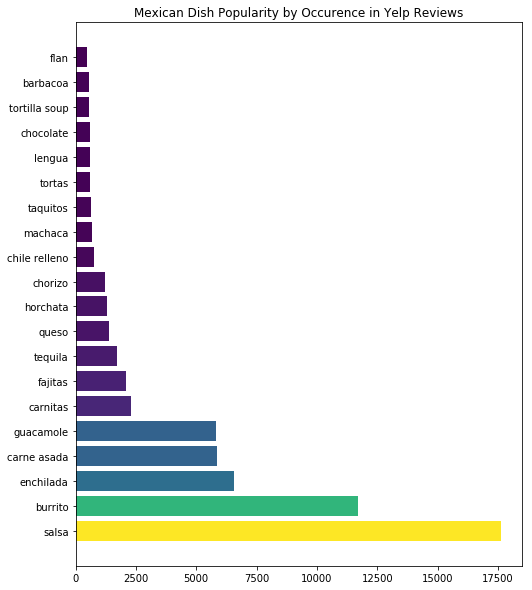

In [18]:
# Show plot
_, _ = myPlot()
plot.show()

*

## Rank Dishes by Review Stars (moderately complex)

*

In [19]:
%%capture --no-stdout

# Normalize star scores; Note: Captures `DataConversionWarning`
# from int64 to float64
minMax = MinMaxScaler((-1, 1))
normedStars = minMax.fit_transform(dfYelpReviews.stars.values.reshape(-1, 1))

In [20]:
# Multiply normalized star scores by dish appearance in review
dishNormedStars = dishInReview.multiply(normedStars)

In [21]:
# Convert to CSR for efficient row-wise operations
dishNormedStars = dishNormedStars.tocsr()

In [22]:
# Append dish normalized star score to dataframe; CAUTION:
# Make sure dataframe of mexican dishes sorted in ascending
# index order or values will map incorrectly.
# dfMexDishes.sort_index(inplace=True)
dfMexDishes["score_in_reviews"] = dishNormedStars.sum(axis=0).A[0]

In [23]:
def myPlot():
    # Get plot parameters to display dish rank by
    # review occurence
    ticks, height, labels = getBarParamsFromDish(dfMexDishes, "count_in_reviews", "dish")    

    # Get plot parameters to display dish rank by
    # normalized star score
    ticksN, heightN, labelsN = getBarParamsFromDish(dfMexDishes, "score_in_reviews", "dish")

    # Configure side-by-side plots
    fig, (ax, axN) = plot.subplots(1, 2, sharey=False)
    fig.set_size_inches(10, 8)

    # Configure color mapping
    cmap = cm.viridis
    norm = matplotlib.colors.Normalize(vmin=min(np.append(height, heightN)), \
                                       vmax=max(np.append(height, heightN)))

    # Generate horizontal bar chart for dish review occurrence
    ax.barh(ticks, height, color=cmap(norm(height)))
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.set_title("Occurence in Yelp Reviews")

    # Generate horizontal bar chart for normalized star scores
    axN.barh(ticksN, heightN, color=cmap(norm(heightN)))
    axN.set_yticks(ticksN)
    axN.set_yticklabels(labelsN)
    axN.set_title("Normalized Star Scores")

    # Set title and layout
    plot.suptitle("Mexican Dish Popularity")
    plot.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    # Return figure and axes
    return fig, (ax, axN)

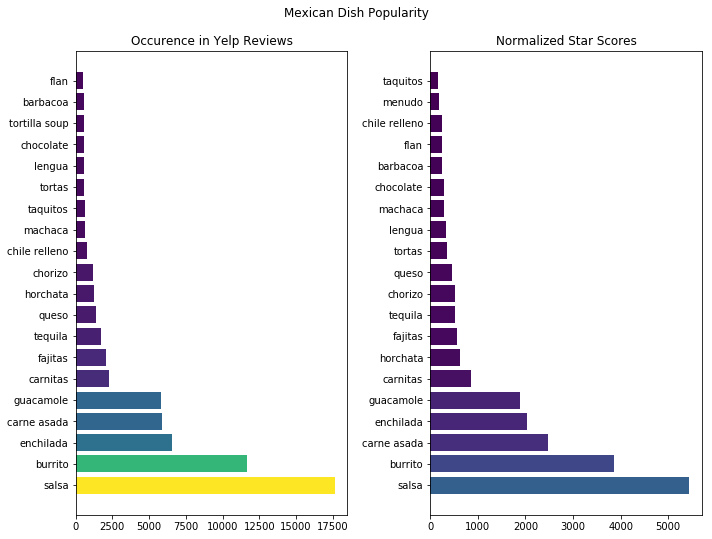

In [24]:
# Show plot
_, _ = myPlot()
plot.show()

*

## Rank Dishes by Review Sentiment (complex)

*

## Summary

*

# Task 05: Restaurant Recommendation

*

## Get Mexican Restaurants

*

In [25]:
# Load businesses into Pandas dataframe
dfYelpBusinesses = pd.read_json(PATH_SOURCE_YELP_BUSINESSES, orient="records", lines=True)

In [26]:
# Group reviews for each restaurant
dfYelpReviewsByRest = dfYelpReviews.groupby(by="business_id").agg({
    "review_id": "count",
    "stars": "sum"
}).reset_index().rename(columns={
    "review_id": "my_review_count",
    "stars": "my_sum_stars"
})

In [27]:
# Join (inner) restaurants to review counts
dfYelpBusinesses = dfYelpBusinesses.merge(dfYelpReviewsByRest, \
                                          on="business_id", \
                                          how="inner")

## Rank Restaurants by Dish Frequency In Reviews

*

In [28]:
%%time

# Sum dish appearances in reviews across restaurants
dishCountRestaurant = sp.sparse.coo_matrix((0, dishInReview.shape[1]))
for b in dfYelpBusinesses.business_id:
    idxs = dfYelpReviews[dfYelpReviews.business_id == b].index
    dishCountRestaurant = sp.sparse.vstack([dishCountRestaurant, \
                                            dishInReview[idxs, ].sum(axis=0)])

CPU times: user 11.4 s, sys: 31.2 ms, total: 11.5 s
Wall time: 12.1 s


In [29]:
# Convert to CSR for efficient row-wise operations
dishCountRestaurant = dishCountRestaurant.tocsr()

In [30]:
# Normalize by number of reviews for each resaurant
dishReviewRatioRestaurant = dishCountRestaurant.multiply(\
        1.0 / dfYelpBusinesses.my_review_count.values[:, np.newaxis])

In [31]:
def getBarParamsFromDishRest(dish, mxDishToRest, dfDish, dfRest, \
                             colDishLabel, colRestLabel, topN=20):
    """Return axis positions (ticks), bar heights, and labels for plotting
            a bar chart from ranked restaraunts for one dish."""
    idxDish = dfDish[dfDish[colDishLabel] == dish].index.values[0]
    data = pd.DataFrame(dfRest[colRestLabel])
    data["height"] = mxDishToRest.getcol(idxDish).todense()
    data = data.sort_values(by="height", ascending=False)\
            .reset_index().iloc[:topN]
    
    # Extract plot parameters from data
    ticks = data.index.values
    height = data.height.values
    labels = data[colRestLabel].values
    
    return ticks, height, labels

In [32]:
def myPlot():
    # Get plot parameters to display restaurant rank
    # for "burrito" by normalized review occurence
    ticks, height, labels = getBarParamsFromDishRest("burrito", \
                                                     dishReviewRatioRestaurant, \
                                                     dfMexDishes, \
                                                     dfYelpBusinesses, \
                                                     "dish", \
                                                     "name")

    # Configure plot
    fig, ax = plot.subplots()
    fig.set_size_inches(8, 10)

    # Configure color mapping
    cmap = cm.viridis
    norm = matplotlib.colors.Normalize()

    # Generate horizontal bar chart 
    plot.barh(ticks, height, color=cmap(norm(height)))

    # Set axes and title
    plot.yticks(ticks, labels)
    plot.xlabel("Normalized (by restaurant) Occurence in Yelp Reviews")
    plot.title("Popular Restaurants for \"burrito\"")
    
    # Return figure and axes
    return fig, ax

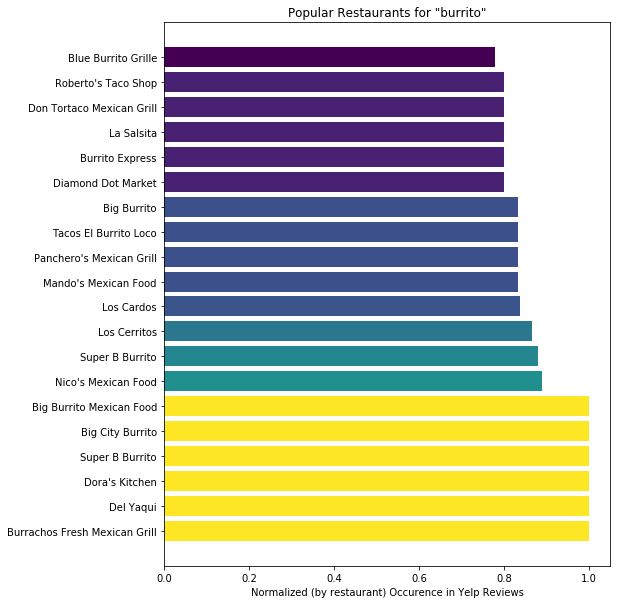

In [33]:
# Show plot
_, _ = myPlot()
plot.show()

*

## Rank Restaurants by Dish Review Stars (moderately complex)

*

In [34]:
%%time

# Sum dish normalized stars across restaurants
dishNormedStarsRestaurant = sp.sparse.coo_matrix((0, dishNormedStars.shape[1]))
for b in dfYelpBusinesses.business_id:
    idxs = dfYelpReviews[dfYelpReviews.business_id == b].index
    dishNormedStarsRestaurant = sp.sparse.vstack([dishNormedStarsRestaurant, \
                                                 dishNormedStars[idxs, ].sum(axis=0)])

CPU times: user 11.3 s, sys: 31.2 ms, total: 11.4 s
Wall time: 11.8 s


In [35]:
# Convert to CSR for efficient row-wise operations
dishNormedStarsRestaurant = dishNormedStarsRestaurant.tocsr()

In [36]:
# Normalize by number of reviews for each resaurant
dishStarRatioRestaurant = dishNormedStarsRestaurant.multiply(\
        1.0 / dfYelpBusinesses.my_review_count.values[:, np.newaxis])

In [37]:
def myPlot():
    # Get plot parameters to display restaurant rank
    # for "burrito" by normalized review occurence
    ticks, height, labels = getBarParamsFromDishRest("burrito", \
                                                     dishReviewRatioRestaurant, \
                                                     dfMexDishes, \
                                                     dfYelpBusinesses, \
                                                     "dish", \
                                                     "name")
    
    # Get plot parameters to display restaurant rank
    # for "burrito" by normalized star score
    ticksN, heightN, labelsN = getBarParamsFromDishRest("burrito", \
                                                        dishStarRatioRestaurant, \
                                                        dfMexDishes, \
                                                        dfYelpBusinesses, \
                                                        "dish", \
                                                        "name")

    # Configure side-by-side plots
    fig, (ax, axN) = plot.subplots(1, 2, sharey=False)
    fig.set_size_inches(10, 8)

    # Configure color mapping
    cmap = cm.viridis
    norm = matplotlib.colors.Normalize(vmin=min(np.append(height, heightN)), \
                                       vmax=max(np.append(height, heightN)))

    # Generate horizontal bar chart for dish review occurrence
    ax.barh(ticks, height, color=cmap(norm(height)))
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.set_title("Normalized (by restaurant) Occurence")

    # Generate horizontal bar chart for normalized star scores
    axN.barh(ticksN, heightN, color=cmap(norm(heightN)))
    axN.set_yticks(ticksN)
    axN.set_yticklabels(labelsN)
    axN.set_title("Normalized Star Scores")

    # Set title and layout
    plot.suptitle("Popular Restaurants for \"burrito\"")
    plot.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    # Return figure and axes
    return fig, (ax, axN)

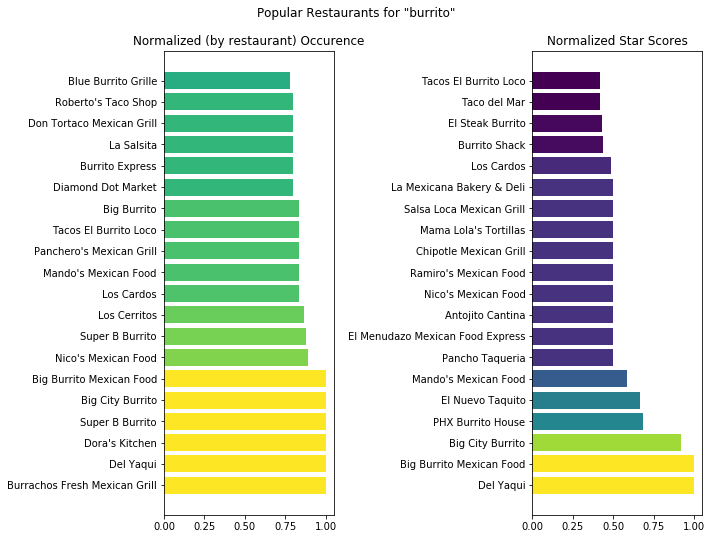

In [38]:
# Show plot
_, _ = myPlot()
plot.show()

*

## Compare Top Dishes and Top Restaurants

*

In [39]:
# Set top N for N restaurant by N dish matrix
TOP_N = 50

In [40]:
# Get top restaurants by star scores
topRest = dfYelpBusinesses.nlargest(TOP_N, "stars")
topRestIdx = topRest.index.values

In [41]:
# Get top dishes by star scores
topDish = dfMexDishes.nlargest(TOP_N, "score_in_reviews")
topDishIdx = topDish.index.values

In [42]:
def myPlot():
    # Plot heat map for top restaurants and dishes
    fig, ax = plot.subplots()
    fig.set_size_inches(10, 10)

    # Generate matrix image
    cmap = cm.viridis
    matrix = dishStarRatioRestaurant.todense()[topRestIdx][:, topDishIdx]
    cax = ax.matshow(matrix)

    # Configure axes
    plot.yticks(range(matrix.shape[0]), topRest.name)
    plot.xticks(range(matrix.shape[0]), topDish.dish, rotation=90)
    ax.xaxis.tick_bottom()

    # Add color bar
    fig.colorbar(cax)

    # Set title and layout
    plot.grid(True, alpha=0.5)
    plot.title("Top {:,} Restaurants and Dishes".format(TOP_N))
    
    # Return figure and axes
    return fig, ax    

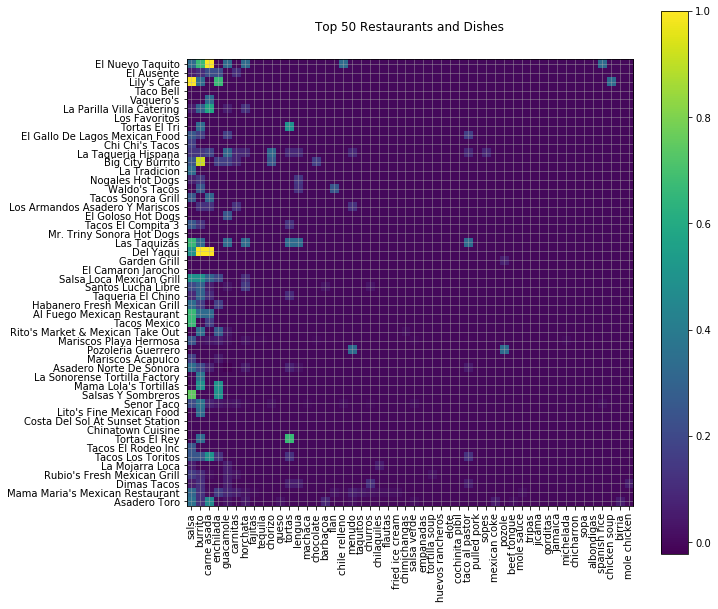

In [43]:
# Show plot
_, _ = myPlot()
plot.show()

*

## Summary

*